In [1]:
import sys
sys.path.append('../')
import torch 
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from utils.dataset import Segmentation_CustomDataset as CustomDataset
from utils.dataset import Test_Segmentation_CustomDataset as Test_CustomDataset
import os
import torch.optim as optim
from utils.__init__ import *
from utils import custom_transforms
from utils import * 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys 
sys.path.append('../')
from model import load_model
from model import * 

2024-05-12 16:28:20.037950: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-12 16:28:20.039184: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 16:28:20.063996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 16:28:20.475478: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


torch.Size([64, 1, 224, 224]) torch.Size([64, 1, 224, 224])
tensor(-1.) tensor(1.)
tensor([0., 1.])


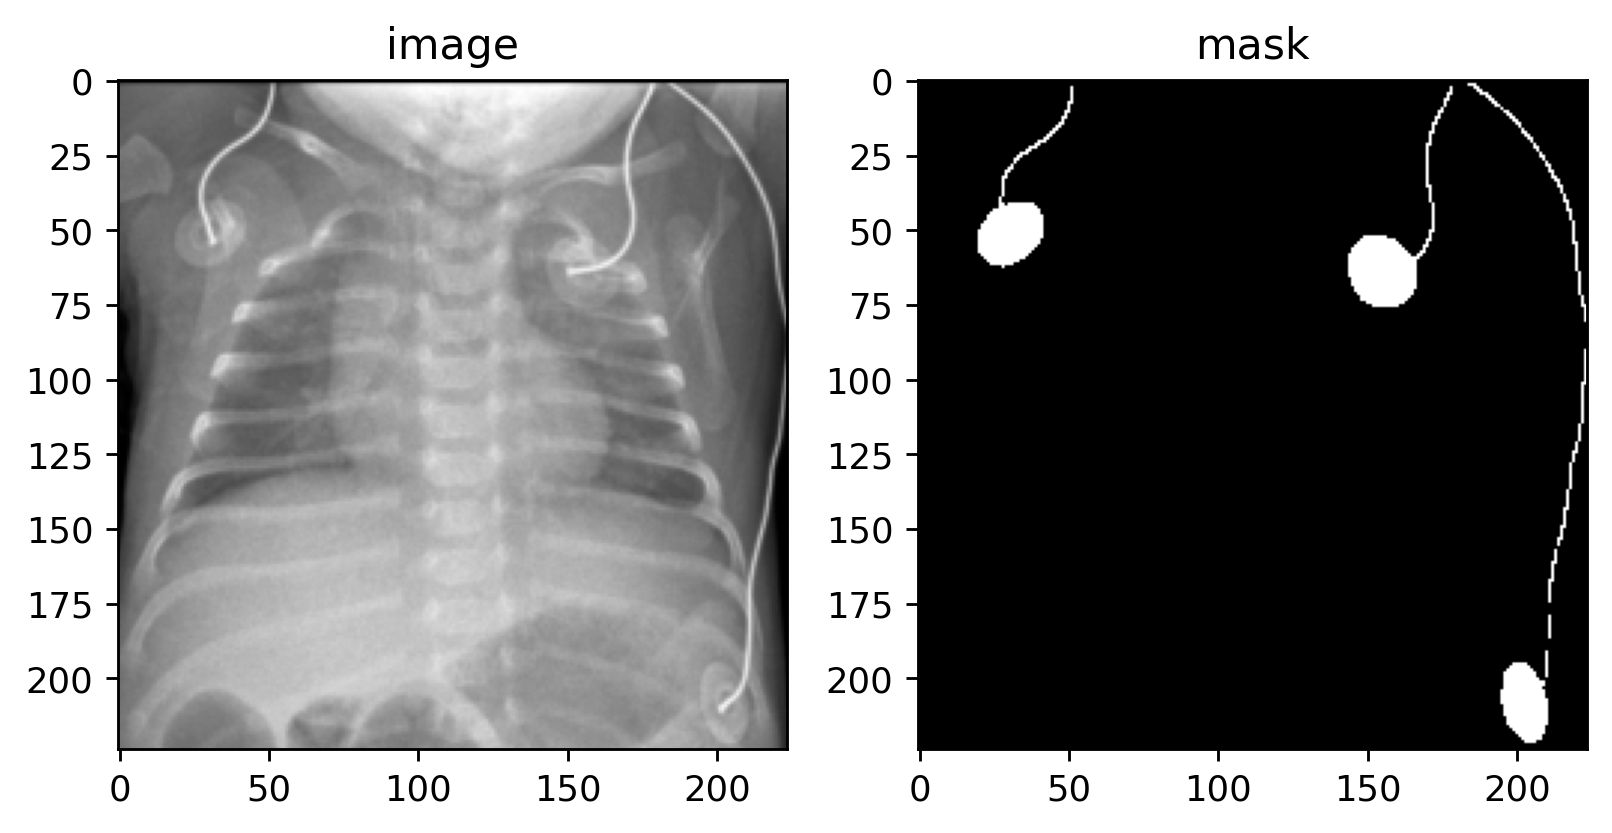

In [2]:
vl_img_dir = '/mnt/HDD/chest-seg/dataset/train_img' 
vl_mask_dir = '/mnt/HDD/chest-seg/dataset/train_mask' 
ts_img_dir = '/mnt/HDD/chest-seg/dataset/test_img'
# ts_mask_dir = '/mnt/HDD/chest-seg/dataset/train_mask'     

transform = {
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
}

# Dataset and DataLoader setup
valid_dataset = CustomDataset(
    image_dir = vl_img_dir,
    mask_dir = vl_mask_dir,
    transform=transform['valid'],
    testing=True,
    seed = 627
)

test_dataset = Test_CustomDataset(
    image_dir = ts_img_dir,
    transform=transform['test'],
    testing=True,  # Disables random transformations for testation
    seed = 627
)
vl_batch, ts_batch = 64,64
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle = False)
test_loader = DataLoader(dataset = test_dataset, batch_size = ts_batch, shuffle = False)

for images, masks, paths in valid_loader:
    print(images.shape, masks.shape)
    print(images.min(), images.max())
    print(masks.unique())
    train_plotting(images, masks)
    break

# for images, masks, paths in test_loader:
#     print(images.shape, masks.shape)
#     train_plotting(images, masks)
#     break


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_save_path = '/mnt/HDD/chest-seg_models/manet_v1_240512'
model_version = 'model_168.pt'

model_name = 'manet'

valid_save_path = os.path.join(model_save_path, 'valid')
test_save_path = os.path.join(model_save_path, 'test')
os.makedirs(valid_save_path, exist_ok=True)
os.makedirs(test_save_path, exist_ok=True)
print(f" Model save path : {model_save_path}")
print(f" Model version : {model_version}")
print(f" Model name : {model_name}")
print(f" Valid save path : {valid_save_path}")
print(f" Test save path : {test_save_path}")

# weight load 
checkpoint = torch.load(os.path.join(model_save_path,model_version), map_location= device)['model_state_dict']

model_loader = load_model.segmentation_models_loader(model_name = model_name)
model = model_loader().to(device)
model.load_state_dict(checkpoint)
# model weight에서 dead weight 파라미터 개수 확인 
model_dead_weight(model = model)
            
test_metrics = {'Accuracy': [], 'mIoU':[], 'Dice':[], 'Hausdorff' : []}

print(f'output shape : {model(torch.randn(2, 1, 224, 224).to(device)).shape}')

 Model save path : /mnt/HDD/chest-seg_models/manet_v1_240512
 Model version : model_168.pt
 Model name : manet
 Valid save path : /mnt/HDD/chest-seg_models/manet_v1_240512/valid
 Test save path : /mnt/HDD/chest-seg_models/manet_v1_240512/test
Model: MAnet loaded successfully!! | pretrained : imagenet
Dead Weight: 11 / 31777361 (0.00%)
output shape : torch.Size([2, 1, 224, 224])


In [4]:
from utils.metrics import calculate_metrics
from utils import * 
threshold = 0
valid_accs, valid_ious, valid_dices, valid_hds= 0, 0, 0, 0
with torch.no_grad():
    model.eval()
    for images, masks, paths in valid_loader:
        images, masks = images.to(device), masks.to(device)
        filenames = [os.path.basename(path) for path in paths]# paths에서 파일명 추출
        ### inference
        outputs = model(images) # input image
        acc, iou,dice, hd = calculate_metrics(outputs.cpu().detach(), masks.cpu().detach(), threshold = threshold)
        valid_accs += acc
        valid_ious += iou
        valid_dices += dice
        valid_hds += hd
        
        save_comparision(images, masks, outputs, threshold = threshold, filenames = filenames, save_dir = valid_save_path)
    for images, paths in test_loader:
        images = images.to(device)
        filenames = [os.path.basename(path) for path in paths]# paths에서 파일명 추출
        ### inference
        outputs = model(images) # input image
        save_prediction(outputs, threshold= threshold, filenames= filenames, save_dir = test_save_path)        # prediction 결과 이미지 저장
test_metrics['Accuracy'].append(float(valid_accs) / len(valid_loader))
test_metrics['mIoU'].append(float(valid_ious) / len(valid_loader))
test_metrics['Dice'].append(float(valid_dices) / len(valid_loader))
test_metrics['Hausdorff'].append(float(valid_hds) / len(valid_loader))

save_metrics(test_metrics, save_dir = valid_save_path)
print("#" * 100)    
print(f"ACC : {test_metrics['Accuracy'][-1]} | mIoU : {test_metrics['mIoU'][-1]} | dice : {test_metrics['Dice'][-1]} | hd : {test_metrics['Hausdorff'][-1]} |")
print("#" * 100)




####################################################################################################
Valid  : 0.024285167921334505 | mIoU : 0.024285167222842574 | dice : 0.04726562276482582 | hd : 223.18119566488502 |
####################################################################################################
